In [1]:
import sys
import pathlib
import time

import matplotlib.pyplot as plt
import numpy as np
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

In [2]:
# Local
cwd = pathlib.Path().resolve()
src = cwd.parent
root = src.parent
sys.path.append(str(src))
sys.path.append(str(root))

from utils.watertopo import WaterTopo
from utils.simulation import Simulation
from utils.utils import count_parameters, create_sequence, recursive_pred, mse_per_timestep
from utils.train import train_and_validate, evaluate_model, train
from models.convlstm import ConvLSTMCell

In [3]:
#initialize GPU -  In case of windows use cuda instead of nps
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print("Is CUDA enabled?",torch.cuda.is_available())
print("Number of GPUs",torch.cuda.device_count())

Is CUDA enabled? True
Number of GPUs 1


In [4]:
class BasicCNN(nn.Module):
    def __init__(self, 
                 input_channels,
                 hidden_size,
                 output_channels=1,
                 bias=True,
                 kernel_size=(3, 3, 3, 3), 
                 pool_kernel_size=1,
                 pool_stride=1, 
                 nonlinearity=F.relu
                 ):
        super(BasicCNN, self).__init__()

        # Convolutional layers
        self.conv1 = nn.Conv2d(input_channels, hidden_size, kernel_size=kernel_size[0], padding=1, bias=bias)
        self.conv2 = nn.Conv2d(hidden_size, hidden_size, kernel_size=kernel_size[1], padding=1, bias=bias)
        self.conv3 = nn.Conv2d(hidden_size, hidden_size, kernel_size=kernel_size[2], padding=1, bias=bias)
        self.conv4 = nn.Conv2d(hidden_size, hidden_size, kernel_size=kernel_size[3], padding=1, bias=bias)

        # Batch normalization layers
        self.batchnorm1 = nn.BatchNorm2d(num_features=hidden_size)
        self.batchnorm2 = nn.BatchNorm2d(num_features=hidden_size)
        self.batchnorm3 = nn.BatchNorm2d(num_features=hidden_size)
        self.batchnorm4 = nn.BatchNorm2d(num_features=hidden_size)

        # Pooling has no learnable parameters, so we can just use one
        self.pool = nn.AvgPool2d(kernel_size=pool_kernel_size, stride=pool_stride)

        # Definition of nonlinearity function
        self.nonlinearity=nonlinearity

        # Last layer
        self.fc = nn.Conv2d(hidden_size, output_channels, kernel_size=1, bias=bias)

    def forward(self, x):
        # Convolutions
        # print("input: ", x.size())
        x = self.pool(self.nonlinearity(self.batchnorm1(self.conv1(x))))
        x = self.pool(self.nonlinearity(self.batchnorm2(self.conv2(x))))
        x = self.pool(self.nonlinearity(self.batchnorm3(self.conv3(x))))
        x = self.pool(self.nonlinearity(self.batchnorm4(self.conv4(x))))
        # print("after 4 convolution: ", x.size())

        # Output layer
        x = self.fc(x)
        # print("output: ", x.size())

        return x

In [5]:
model = BasicCNN(input_channels=2,
                 hidden_size=32,
                 output_channels=1,
                 bias=True,
                 kernel_size=(3, 3, 3, 3), 
                 pool_kernel_size=1,
                 pool_stride=1, 
                 nonlinearity=F.relu
                 ).to(device)

print(f"CNN --> num. trainable parameters:{count_parameters(model):8d}")

CNN --> num. trainable parameters:   28641


In [6]:
# Contents in this cell are copied from train.py and utils.py, and adjusted slightly to fit this application

def evaluate_model(model, test_loader, criterion, device):
    model.eval()  # Set the model to evaluation mode
    test_loss = 0

    with torch.no_grad():  # No need to track gradients during evaluation
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            test_loss += loss.item()

    avg_test_loss = test_loss / len(test_loader)
    return avg_test_loss


def train_and_validate(model, train_loader, val_loader, criterion, optimizer, num_epochs, device, save_path):
    best_val_loss = float("inf")  # Track the best validation loss
    train_losses = []
    val_losses = []

    start_time = time.time()  # Start training time

    for epoch in range(num_epochs):
        # Training Phase
        model.train()
        total_train_loss = 0
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()

        avg_train_loss = total_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # Validation Phase
        avg_val_loss = evaluate_model(model, val_loader, criterion, device)
        val_losses.append(avg_val_loss)

        # Save Best Model
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), save_path)

        if (epoch + 1) % 1 == 0:
            print(f'Epoch {epoch+1}/{num_epochs}', f'Train Loss: {avg_train_loss:.4f}, '
                  f'Validation Loss: {avg_val_loss:.4f}', f'Best Validation Loss: {best_val_loss:.4f}')
    train_time = time.time() - start_time
    print("Training complete.")
    return train_losses, val_losses, best_val_loss, train_time


def train(
        model,
        device,
        root,
        model_name,
        channels=2,
        T=5,
        H=1,
        sim_amount=3,
        training_size=0.8,
        use_augmented_data=True,
        batch_size=4,
        num_epochs = 200,
        lr = 0.0005,
        criterion = nn.MSELoss(),
        optimizer = optim.AdamW,
        ):

    """
    This method trains a simple RNN. Given a single timestep consisting of water depth and topography (both 64*64), the RNN predicts a single step ahead. The best model state is
    saved following the save_path, and also returned by the method.
    
    Description of arguments:
    - model: the model to be trained, should be an instance of the class SimpleRNN;
    - channels (int): number of channels that the loaded model is compatible with (default 2, i.e. DEM & WED);
    - sim_amount (int): number of simulations of which the data is loaded and used for training, with a maximum of 400;
    - training_size (float): fraction of data to use for training (validation uses the fraction 1 - training_size);
    - use_augmented_data (boolean): if True, the train function will include augmented data when (randomly) selecting training and validation data;
    - batch_size (int): batch size used during training (you can modify this based on your requirements);
    - T (int): number of input time steps. Make sure this number is compatible with the defined model;
    - H (int): number of predicted time steps (default 1). Make sure this number is compatible with the defined model;
    - num_epochs (int): number of epochs used during training;
    - lr (float): learning rate used during training;
    - criterion: Loss function, default nn.MSELoss()
    - optimizer: optimizer used for training, default optim.AdamW
    - defice: the device used for training the model (i.e. CUDA [GPU] or CPU).
    - model_name (string): the best model state will be saved in ../results/trained_models/ under this name

    returns: model, train_losses, val_losses, best_val_loss, time
    """
    # load simulations to be used for training
    if channels == 2:
        sims = WaterTopo.load_simulations(str(root)+"/data/normalized_data/tra_val", sim_amount=sim_amount, number_grids=64, use_augmented_data=use_augmented_data)
    elif channels == 4:
        sims = Simulation.load_simulations(str(root)+"/data/normalized_data/tra_val", sim_amount=sim_amount, number_grids=64, use_augmented_data=use_augmented_data)

    X, Y = create_sequence(sims, T, H)

    # We keep track of indexes of train and validation.
    X_tra, X_tst, Y_tra, Y_tst, ix_tra, ix_tst = train_test_split(
        X, Y, np.arange(X.shape[0]), test_size=1-training_size, shuffle=True, random_state=42)
    
    # Split the existing test dataset into validation and test sets (50/50 split)
    X_val, X_tst, Y_val, Y_tst, ix_val, ix_tst = train_test_split(
        X_tst, Y_tst, ix_tst, test_size=0.5, shuffle=True, random_state=42)
    
    # print(X_tra.shape)
    # print(Y_tra.shape)
    
    #create datasets and data loaders
    train_dataset = TensorDataset(torch.tensor(X_tra, dtype=torch.float32), torch.tensor(Y_tra, dtype=torch.float32))
    val_dataset = TensorDataset(torch.tensor(X_val, dtype=torch.float32), torch.tensor(Y_val, dtype=torch.float32))

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    # defining the optimizer
    optimizer = optimizer(model.parameters(), lr=lr)

    # defining the save path
    save_path = "../results/trained_models/" + model_name

    # training
    print("starting training")
    train_losses, val_losses, best_val_loss, time = train_and_validate(model, train_loader, val_loader, criterion, optimizer, num_epochs, device, save_path)

    # Load the best model
    model.load_state_dict(torch.load(save_path))

    return model, train_losses, val_losses, best_val_loss, time


def create_sequence(series, T=5, H=1):
    """
    Create sequence of input X and output Y from a last of Simulation or WaterTopo objects:
    - series: list of Simulation or WaterTopo objects


    - X: input for NN, shape [T * channels * height * width]
    - Y: output for NN [H * height * width]
    """
    if isinstance(series[0], Simulation):
        channels = 4
    elif isinstance(series[0], WaterTopo):
        channels = 2
    else:
        raise Exception("Wrong input type, use a list of Simulations or WaterTopo objects.")
    

    duration = series[0].wd.shape[0]

    height = series[0].wd.shape[1]
    width = series[0].wd.shape[2]

    seq_per_sim = duration-T-H
    num_sims = len(series)

    X = np.zeros((seq_per_sim*num_sims, T, channels, height, width))
    Y = np.zeros((seq_per_sim*num_sims, H, channels-1, height, width))

    for i,serie in enumerate(series):
        j = i * seq_per_sim
        for t in range(seq_per_sim):
            if channels == 2:               
                X[j+t:j+t+T, :,0,:,:] = np.tile(serie.topography, (T,1,1))
                X[j+t:j+t+T, :,1,:,:] = serie.wd[t:t+T]
                
                Y[j+t+T : j+t+T+H,:,0,:,:] = serie.wd[t+T:t+T+H]

            elif channels == 4:
                X[j+t:j+t+T, :,0,:,:] = np.tile(serie.topography, (T,1,1))
                X[j+t:j+t+T, :,1,:,:] = serie.wd[t:t+T]
                X[j+t:j+t+T, :,2,:,:] = serie.wd[t:t+T]
                X[j+t:j+t+T, :,3,:,:] = serie.wd[t:t+T]

                Y[j+t+T: j+t+T+H, :,0,:,:] = serie.wd[t+T:t+T+H]
                Y[j+t+T: j+t+T+H, :,1,:,:] = serie.vx[t+T:t+T+H]
                Y[j+t+T: j+t+T+H, :,2,:,:] = serie.vy[t+T:t+T+H]


    # print("shape of X: ", X.shape)
    # print("shape of Y: ", Y.shape)

    if H==1 and T==1:
        X = X[:,0,:,:,:]
        Y = Y[:,0,:,:,:]

    print("shape of X: ", X.shape)
    print("shape of Y: ", Y.shape)

    return X, Y

In [7]:
model, train_losses, val_losses, best_val_loss, time = train(model,
                                                 device=device,
                                                 root=root,
                                                 model_name = 'CNN_kevin',
                                                 channels=2,
                                                 T=1,
                                                 H=1,
                                                 sim_amount=80,
                                                 training_size=0.8,
                                                 use_augmented_data=False,
                                                 batch_size=10,
                                                 num_epochs=20,
                                                 lr=0.005,
                                                 criterion=nn.MSELoss(),
                                                 optimizer=optim.AdamW,
                                                 )

shape of X:  (7600, 2, 64, 64)
shape of Y:  (7600, 1, 64, 64)
Epoch 1/20 Train Loss: 0.0028, Validation Loss: 0.0006 Best Validation Loss: 0.0006
Epoch 2/20 Train Loss: 0.0009, Validation Loss: 0.0004 Best Validation Loss: 0.0004
Epoch 3/20 Train Loss: 0.0007, Validation Loss: 0.0004 Best Validation Loss: 0.0004
Epoch 4/20 Train Loss: 0.0006, Validation Loss: 0.0003 Best Validation Loss: 0.0003
Epoch 5/20 Train Loss: 0.0006, Validation Loss: 0.0003 Best Validation Loss: 0.0003
Epoch 6/20 Train Loss: 0.0006, Validation Loss: 0.0003 Best Validation Loss: 0.0003
Epoch 7/20 Train Loss: 0.0006, Validation Loss: 0.0003 Best Validation Loss: 0.0003
Epoch 8/20 Train Loss: 0.0006, Validation Loss: 0.0005 Best Validation Loss: 0.0003
Epoch 9/20 Train Loss: 0.0006, Validation Loss: 0.0003 Best Validation Loss: 0.0003
Epoch 10/20 Train Loss: 0.0006, Validation Loss: 0.0003 Best Validation Loss: 0.0003
Epoch 11/20 Train Loss: 0.0006, Validation Loss: 0.0003 Best Validation Loss: 0.0003
Epoch 12/20 

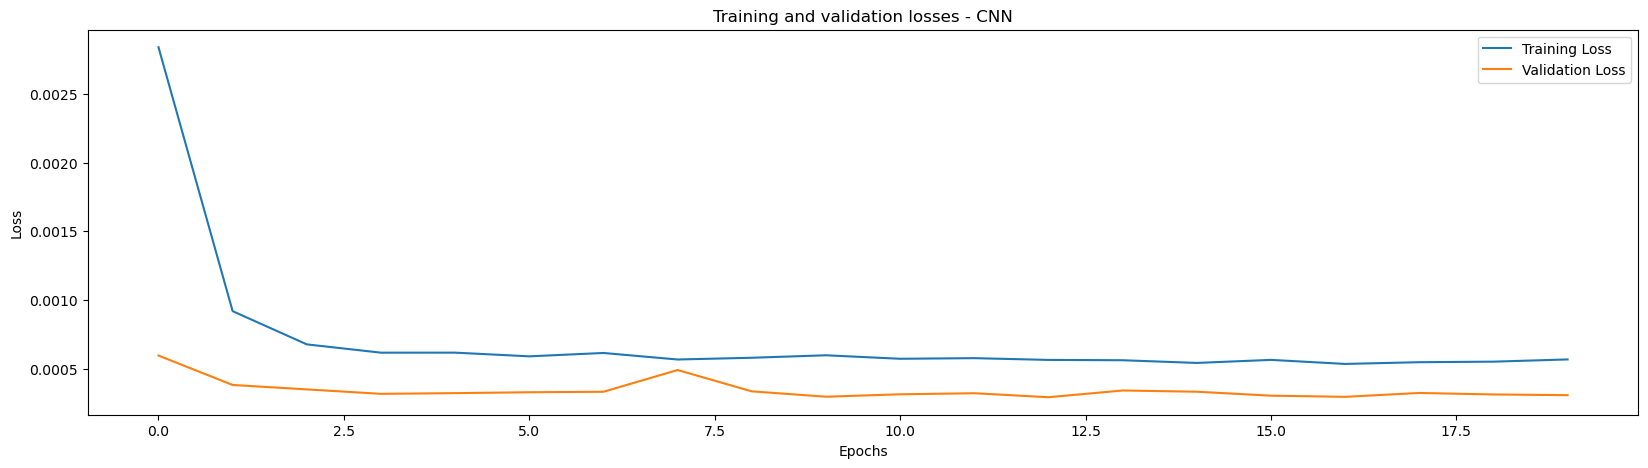

In [8]:
# Plot validation loss
fig, ax = plt.subplots(figsize=(20, 5))
ax.plot(train_losses, label='Training Loss')
ax.plot(val_losses, label='Validation Loss')
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
ax.set_title('Training and validation losses - CNN')
ax.legend()

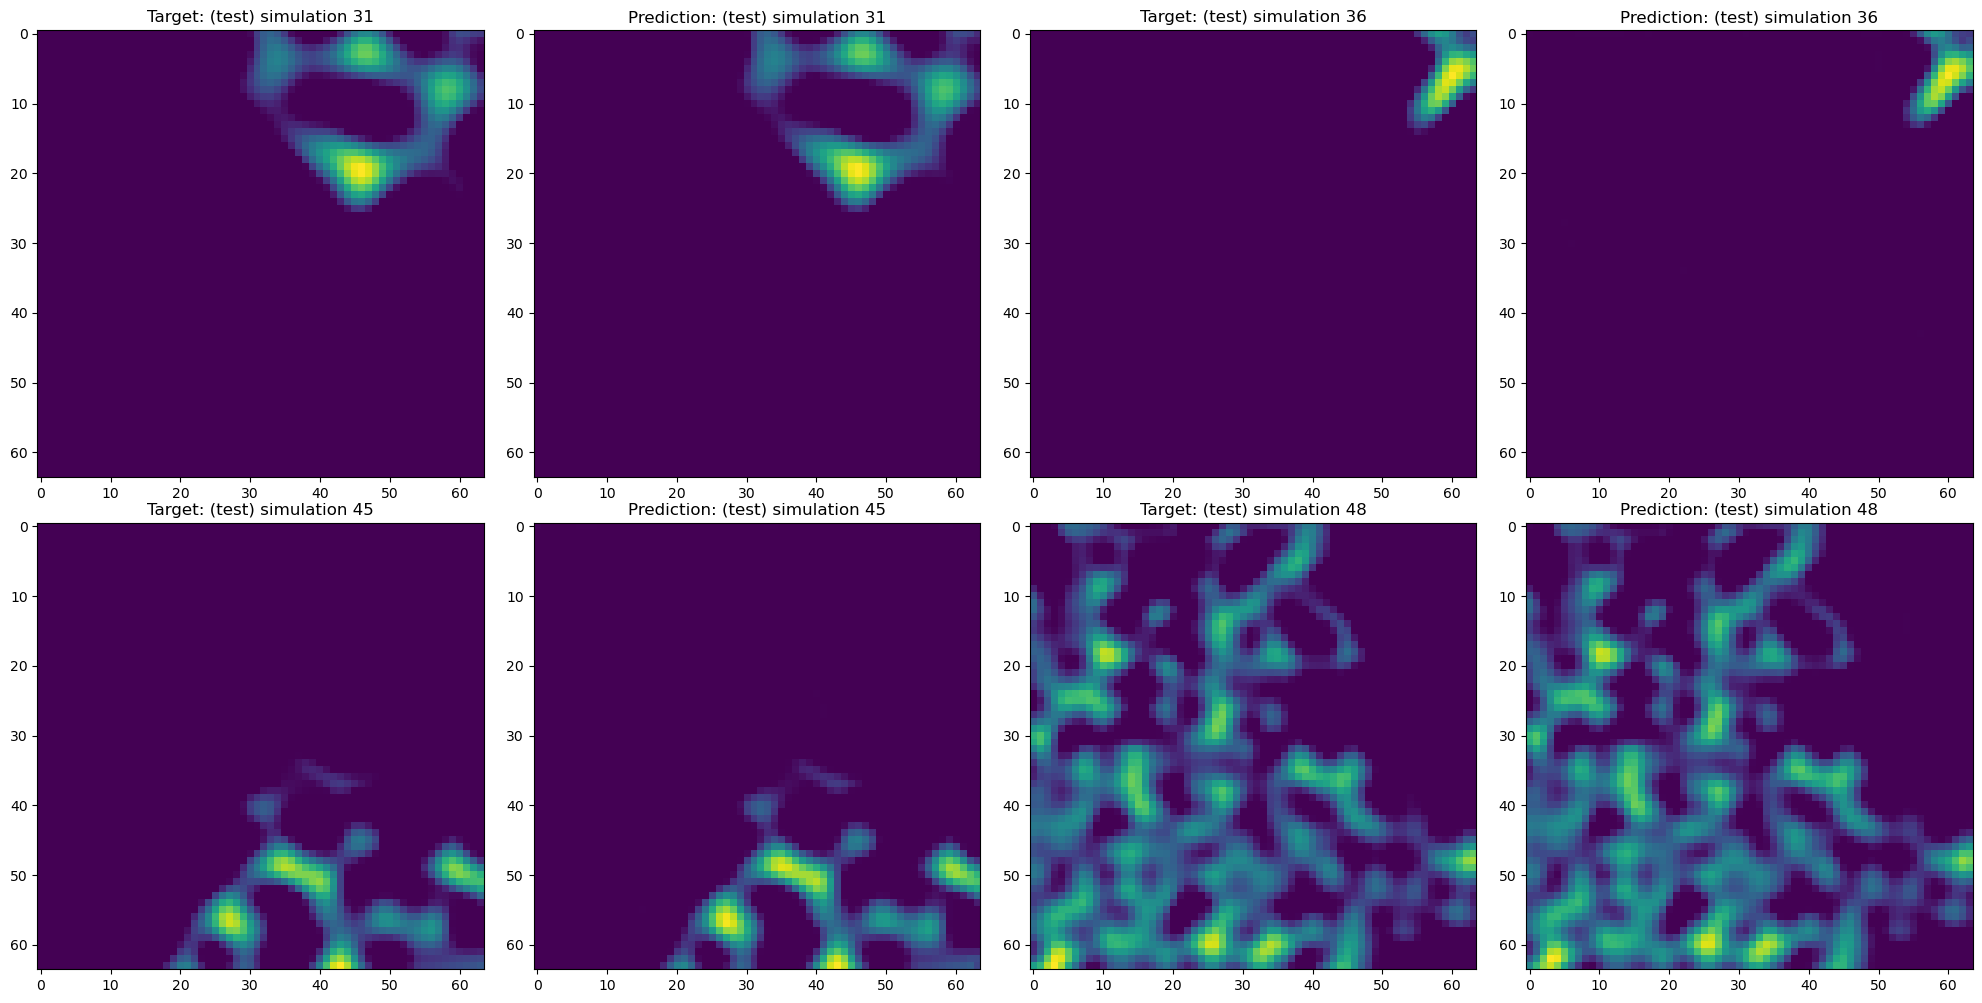

In [9]:
# Let's try the model!
model.eval()

grid_size = 64
channels = 2

f,axs = plt.subplots(2, 4, figsize=(20,10))
axs = axs.reshape(-1)

for i in range(0, len(axs), 2):
  with torch.no_grad():
      # Randomly select a simulation
      random_index = random.randint(0, 80)
      sim = WaterTopo.load_simulations(str(root)+"/data/normalized_data/tra_val/", 
                                       1, 
                                       grid_size)[0]

      inputs = np.zeros((1, channels, grid_size, grid_size))
      targets = np.zeros((1, grid_size, grid_size))

      id = random.randint(0, 95)

      inputs[0, 0,:,:] = sim.topography
      inputs[0, 1,:,:] = sim.return_timestep(id)
      targets[0, :,:]  = sim.return_timestep(id+1)

      # print(inputs.shape)
      # print(targets.shape)
      
      # inputs, target = inputs.to(device).unsqueeze(0), target.to(device).unsqueeze(0)

      # Predict
      inputs = torch.tensor(inputs, dtype=torch.float32).to(device)
      inputs.cpu()
      prediction = model(inputs).cpu()

      # Plotting inputs (time series)
      axs[i].imshow(targets[0,:,:])
      axs[i+1].imshow(prediction[0,0,:,:])

      axs[i].set_title(f"Target: (test) simulation {random_index}")
      axs[i+1].set_title(f"Prediction: (test) simulation {random_index}")

f.tight_layout()

In [10]:
# # Let's try the model recursively!
# model.eval()

# grid_size = 64
# channels = 2
# sim_length = 96

# # Let's do a crude Monte Carlo with a single model, calculating the loss after each timestep
# sim = WaterTopo.load_simulations(str(root)+"/data/normalized_data/tra_val/", 1, grid_size)[0]
# inputs = np.zeros((1, channels, grid_size, grid_size))
# targets = np.zeros((sim_length, grid_size, grid_size))

# # Select the time step where you want to start
# id = 0

# inputs[0, 0, :, :] = sim.topography
# inputs[0, 1, :, :] = sim.return_timestep(id)
# inputs = torch.tensor(inputs, dtype=torch.float32).to(device)
# inputs.cpu()

# for t in range(1, sim_length+1):
#    targets[t-1,:,:] = sim.return_timestep(t)
# targets = torch.tensor(targets, dtype=torch.float32).cpu()

# outputs = torch.zeros(targets.shape).cpu()

# # print(inputs.shape)
# # print(targets.shape)
# # print(outputs.shape)
# # print(input.shape)

# for t in range(0, sim_length):
#    outputs[t,:,:] = model(input).cpu()
#    inputs[0,1,:,:] = outputs[t,:,:]


# # outputs = recursive_pred(model, inputs, 96, include_first_timestep=False)
   
# mse = mse_per_timestep(targets, outputs)

# fig, ax = plt.subplots()
# ax.plot(np.arange(0, len(mse)), mse, label="MSE")
# ax.set_xlabel("time steps")
# ax.set_ylabel("MSE")
# ax.set_title("CNN - MSE per timestep")

# # f,axs = plt.subplots(2, 4, figsize=(20,10))
# # axs = axs.reshape(-1)

# # for i in range(0, len(axs), 2):
# #   with torch.no_grad():
# #       # Randomly select a simulation
# #       random_index = random.randint(0, 80)
# #       sim = WaterTopo.load_simulations(str(root)+"/data/normalized_data/tra_val/", 
# #                                        1, 
# #                                        grid_size)[0]

# #       inputs = np.zeros((1, channels, grid_size, grid_size))
# #       targets = np.zeros((1, grid_size, grid_size))

# #       id = random.randint(0, 96)

# #       inputs[0, 0,:,:] = sim.topography
# #       inputs[0, 1,:,:] = sim.return_timestep(id)
# #       targets[0, :,:]  = sim.return_timestep(id+1)

# #       # print(inputs.shape)
# #       # print(targets.shape)
      
# #       # inputs, target = inputs.to(device).unsqueeze(0), target.to(device).unsqueeze(0)

# #       # Predict
# #       inputs = torch.tensor(inputs, dtype=torch.float32).to(device)
# #       inputs.cpu()
# #       prediction = model(inputs).cpu()

# #       # Plotting inputs (time series)
# #       axs[i].imshow(targets[0,:,:])
# #       axs[i+1].imshow(prediction[0,0,:,:])

# #       axs[i].set_title(f"Target: (test) simulation {random_index}")
# #       axs[i+1].set_title(f"Prediction: (test) simulation {random_index}")

# # f.tight_layout()

TypeError: conv2d() received an invalid combination of arguments - got (method, Parameter, Parameter, tuple, tuple, tuple, int), but expected one of:
 * (Tensor input, Tensor weight, Tensor bias, tuple of ints stride, tuple of ints padding, tuple of ints dilation, int groups)
      didn't match because some of the arguments have invalid types: (!method!, !Parameter!, !Parameter!, !tuple of (int, int)!, !tuple of (int, int)!, !tuple of (int, int)!, int)
 * (Tensor input, Tensor weight, Tensor bias, tuple of ints stride, str padding, tuple of ints dilation, int groups)
      didn't match because some of the arguments have invalid types: (!method!, !Parameter!, !Parameter!, !tuple of (int, int)!, !tuple of (int, int)!, !tuple of (int, int)!, int)
